<a href="https://colab.research.google.com/github/NguyenVanLuu821/Term-Project-of-course-AI/blob/main/Calculate_the_Area_of_Defects_on_Dragon_Fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Import library 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
import cv2

#2.Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/AI/Data/thanhlong1.zip

Archive:  /content/drive/MyDrive/AI/Data/thanhlong1.zip
   creating: thanhlong1/
  inflating: thanhlong1/10000.jpg    
  inflating: thanhlong1/10001.jpg    
  inflating: thanhlong1/10010.jpg    
  inflating: thanhlong1/10011.jpg    
  inflating: thanhlong1/10020.jpg    
  inflating: thanhlong1/10021.jpg    
  inflating: thanhlong1/10030.jpg    
  inflating: thanhlong1/10031.jpg    
  inflating: thanhlong1/10040.jpg    
  inflating: thanhlong1/10041.jpg    
  inflating: thanhlong1/10050.jpg    
  inflating: thanhlong1/10051.jpg    
  inflating: thanhlong1/10060.jpg    
  inflating: thanhlong1/10061.jpg    
  inflating: thanhlong1/10070.jpg    
  inflating: thanhlong1/10071.jpg    
  inflating: thanhlong1/10080.jpg    
  inflating: thanhlong1/10081.jpg    
  inflating: thanhlong1/10090.jpg    
  inflating: thanhlong1/10091.jpg    
  inflating: thanhlong1/10100.jpg    
  inflating: thanhlong1/10101.jpg    
  inflating: thanhlong1/10110.jpg    
  inflating: thanhlong1/10111.jpg    
  infla

In [ ]:
#define function
x_train = []
y_train = []
count = 0
stt = 1000

#import img and img_mask
link = 'thanhlong1/'+str(stt+count)+str(0)+'.jpg'
link_mask = 'thanhlong1/'+str(stt+count)+str(1)+'.jpg'
img = cv2.imread(link)
mask=cv2.imread(link_mask)

#define color for img and img_mask
while (type(img)!=type(None)):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  x_train.append(img)
  y_train.append(mask)
  count = count+ 1
  stt   = stt  + 1
  link = 'thanhlong1/'+ str(stt+count) + str(0)+'.jpg'
  link_mask = 'thanhlong1/'+ str(stt+count) + str(1)+'.jpg'
  img = cv2.imread(link)
  mask=cv2.imread(link_mask)

In [ ]:
#handling data
x_train= np.array(x_train).astype('float32')
y_train= np.array(y_train).astype('float32')
x_train/=255
y_train/=255
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (245, 128, 128, 3)
y_train shape: (245, 128, 128)


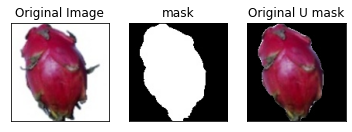

In [ ]:
#reshape
y_train = y_train.reshape(len(y_train),128,128,1)
# plt.axis('off')
img = x_train[50]
mask = y_train[50].squeeze()
mask = np.stack((mask,)*3, axis=-1)

#print
titles = ['Original Image', 'mask', 'Original U mask']
images = [img, mask, img*mask]
for i in range(3):
  plt.subplot(2,3, i+1), plt.imshow(images[i], 'gray')
  plt.title(titles[i])
  plt.xticks([]), plt.yticks([])

In [ ]:
print('x_train_shape:',x_train.shape)
print('y_train_shape:',y_train.shape)

x_train_shape: (245, 128, 128, 3)
y_train_shape: (245, 128, 128, 1)


#3.Create model


In [ ]:
def unet(pretrained_weights = None, input_size = (128, 128, 3)):
  inputs = Input(input_size)
  
  #down sampling 
  conv1 = Conv2D(8, 3, activation='relu', padding='same') (inputs)
  conv1 = Conv2D(8, 3, activation='relu', padding='same') (conv1)
  pool1 = MaxPooling2D() (conv1)

  conv2 = Conv2D(16, 3, activation='relu', padding='same') (pool1)
  conv2 = Conv2D(16, 3, activation='relu', padding='same') (conv2)
  pool2 = MaxPooling2D() (conv2)

  conv3 = Conv2D(32, 3, activation='relu', padding='same') (pool2)
  conv3 = Conv2D(32, 3, activation='relu', padding='same') (conv3)
  pool3 = MaxPooling2D() (conv3)

  conv4 = Conv2D(64, 3, activation='relu', padding='same') (pool3)
  conv4 = Conv2D(64, 3, activation='relu', padding='same') (conv4)
  pool4 = MaxPooling2D() (conv4)
  
  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool4)
  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv5)
  pool5 = MaxPooling2D() (conv5)

  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool5)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv6)
  pool6 = MaxPooling2D() (conv6)
  
  #upsampling 
  conv7 = Conv2D(512, 3, activation='relu', padding='same') (pool6)
  conv7 = Conv2D(512, 3, activation='relu', padding='same') (conv7)
  up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (conv7)
  merger7 = Concatenate(axis=3)([conv6, up7])
  
  conv8 = Conv2D(256, 3, activation='relu', padding='same') (merger7)
  conv8 = Conv2D(256, 3, activation='relu', padding='same') (conv8)
  up8 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (conv8)
  merger8 = Concatenate(axis=3)([conv5, up8])
  
  conv9 = Conv2D(128, 3, activation='relu', padding='same') (merger8)
  conv9 = Conv2D(128, 3, activation='relu', padding='same') (conv9)
  up9 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same') (conv9)
  merger9 = Concatenate(axis=3)([conv4, up9])
  
  conv10 = Conv2D(64, 3, activation='relu', padding='same') (merger9)
  conv10 = Conv2D(64, 3, activation='relu', padding='same') (conv10)
  up10= Conv2DTranspose(8, 2, strides=(2, 2), padding='same') (conv10)
  merger10 = Concatenate(axis=3)([conv3, up10])
  
  conv11= Conv2D(32, 3, activation='relu', padding='same') (merger10)
  conv11 = Conv2D(32, 3, activation='relu', padding='same') (conv11)
  up11 = Conv2DTranspose(4, 2, strides=(2, 2), padding='same') (conv11)
  merger11 = Concatenate(axis=3)([conv2, up11])

  conv12 = Conv2D(16, 3, activation='relu', padding='same') (merger11)
  conv12 = Conv2D(16, 3, activation='relu', padding='same') (conv12)
  up12 = Conv2DTranspose(2, 2, strides=(2, 2), padding='same') (conv12)
  merger12 = Concatenate(axis=3)([conv1, up12])

  #classification 
  conv13 = Conv2D(16, 3, activation='relu', padding='same') (merger12)
  conv13 = Conv2D(16, 3, activation='relu', padding='same') (conv13)
  outputs = Conv2D(1, 1, activation='sigmoid') (conv13)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics =['accuracy'] )

  model.summary()
  
  return model

In [ ]:
model = unet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d_1[0][0]']           

In [ ]:
print('x_train_shape:',x_train.shape)
print('y_train_shape:',y_train.shape)

x_train_shape: (245, 128, 128, 3)
y_train_shape: (245, 128, 128, 1)


#4.Training

In [ ]:
history = model.fit(x_train,y_train,epochs=20,batch_size=64,verbose = 1,validation_split=0.2)

Epoch 1/20
4/4 [==============================] - 1s 116ms/step - loss: 0.0280 - accuracy: 0.9258 - val_loss: 0.0711 - val_accuracy: 0.9111
Epoch 2/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0320 - accuracy: 0.9244 - val_loss: 0.0689 - val_accuracy: 0.9113
Epoch 3/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0271 - accuracy: 0.9261 - val_loss: 0.0907 - val_accuracy: 0.9083
Epoch 4/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0393 - accuracy: 0.9228 - val_loss: 0.0735 - val_accuracy: 0.9114
Epoch 5/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0301 - accuracy: 0.9253 - val_loss: 0.0762 - val_accuracy: 0.9110
Epoch 6/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0252 - accuracy: 0.9268 - val_loss: 0.0717 - val_accuracy: 0.9124
Epoch 7/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0244 - accuracy: 0.9270 - val_loss: 0.0981 - val_accuracy: 0.9075
Epoch 8/20
4/4 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


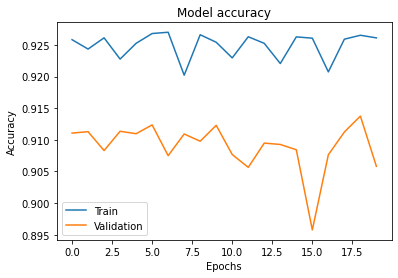

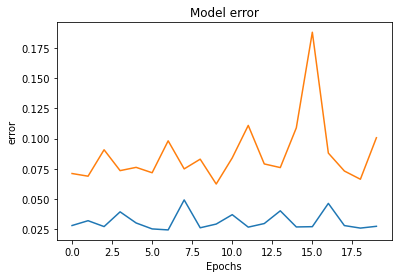

In [ ]:
#plot figure
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc='upper_left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model error')
plt.ylabel('error')
plt.xlabel('Epochs')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
model = keras.models.load_model('model.h5')

#5.Predict

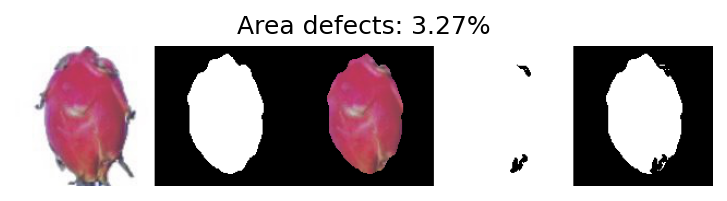

In [ ]:
from tensorflow.python.platform.tf_logging import error
def make_squarebw(img):
    #Getting the bigger side of the image
    s = max(img.shape[0:2])
    #Creating a white square   
    f = np.zeros((s,s),np.uint8)
    #Getting the centering position
    ax,ay = (s - img.shape[1])//2,(s - img.shape[0])//2
    #Pasting the 'image' in a centering position
    f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img
    return f
def make_square(img):
    #Getting the bigger side of the image
    s = max(img.shape[0:2])
    #Creating a dark square with NUMPY  
    f = np.zeros((s,s,3),np.uint8)
    #Getting the centering position
    ax,ay = (s - img.shape[1])//2,(s - img.shape[0])//2
    #Pasting the 'image' in a centering position
    f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img
    return f

pre = Image.open('9.jpg')
pre= np.array(pre)
pre = make_square(pre)
pre = cv2.resize(pre, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
tam = cv2.cvtColor(pre, cv2.COLOR_RGB2HSV)
tam = cv2.fastNlMeansDenoisingColored(tam,None,10,6,7,21)

pre = pre.astype('float32')
tam = tam.astype('float32')
pre /=255
tam /=255

#load model
model = keras.models.load_model('model.h5')

#predict the mask 
pred = model.predict(np.expand_dims(pre, 0))

#mask processing 
sum=0.0
count=0
h_const=0.35
s_const=1.3
v_const=6
avg_const=1.22
constants=6 
err_pixel = 0
plus = 2
mask  = pred.squeeze()
mask = cv2.copyMakeBorder(mask, constants, constants, constants, constants, cv2.BORDER_CONSTANT,value=[0,0,0])
mask = cv2.resize(mask, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
mask = np.stack((mask,)*3, axis=-1)
mask[mask >= 0.5] = 1 
mask[mask < 0.5] = 0 
M,N,k = mask.shape
for i in range(0,M):
    for j in range(0,N):
        if (mask[i,j,0]==1):
            sum+=tam[i,j,0]*h_const+tam[i,j,1]*s_const+tam[i,j,2]*v_const
            count+=1
avg=sum/count/avg_const
ermsk=np.zeros((128,128,3),np.uint8)
nemsk = cv2.copyMakeBorder(mask, 2,2,2,2, cv2.BORDER_CONSTANT,value=[0,0,0])
newtam = cv2.copyMakeBorder(tam, 2,2,2,2, cv2.BORDER_CONSTANT,value=[0,0,0])

for i in range(plus,M+plus):
    for j in range(plus,N+plus):
        if ((nemsk[i,j,0]>0.8) & (newtam[i,j,0]*h_const+newtam[i,j,1]*s_const+newtam[i,j,2]*v_const<avg)):
            lim = (plus*2+1)*(plus*2+1)-1
            xq = 0
            for a in range(-plus,plus+1):
                for b in range(-plus,plus+1):
                    if (a,b != (0,0)):
                        if ((nemsk[i+a,j+b,0]>0.8) & (newtam[i+a,j+b,0]*h_const+newtam[i+a,j+b,1]*s_const+newtam[i+a,j+b,2]*v_const<avg)):
                            xq = xq + 1                
            if (xq/lim > 0.5):
                err_pixel = err_pixel + 1
                ermsk[i-plus,j-plus,0]=1
                ermsk[i-plus,j-plus,1]=1
                ermsk[i-plus,j-plus,2]=1

#Negative ermsk 
L = 1.0
a = cv2.cvtColor(ermsk, cv2.COLOR_BGR2GRAY)
for x in range(0, M):
    for y in range(0, N):
            r = a[x, y]
            s = L - r
            a[x, y] = s
ermsk = cv2.cvtColor(a, cv2.COLOR_GRAY2BGR)

# show the mask and the segmented image
percent = round(err_pixel/count*100, 2)
titles = 'Area defects: ' +  str(percent)+'%'
imgout = np.concatenate([pre,mask,mask*pre, ermsk, ermsk*mask], axis = 1)
plt.figure(figsize=(6, 2), dpi= 150) 
plt.axis('off')
plt.title(titles)
plt.imshow(imgout)
plt.show()